# Computing leaf tortuosity from segmented leaf microCT stacks
## Using the method in Earles et al. (to be submitted)

__Created__ on 2018-03-21 by Guillaume Théroux-Rancourt (guillaume.theroux-rancourt@boku.ac.at)

__Last edited__ on 2018-03-23 by Guillaume Théroux-Rancourt

I've got help from here:
- https://stackoverflow.com/questions/28187867/geodesic-distance-transform-in-python
- https://stackoverflow.com/questions/47540926/get-the-largest-connected-component-of-segmentation-image

To do:
- Clean up the import packages.
- Remove unused functions.

In [57]:
import skimage.io as io
from skimage import img_as_int, img_as_ubyte, img_as_float, feature, measure, color, morphology, filters
import numpy as np
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
import random
import matplotlib.pyplot as plt
from skimage.util import invert
import skfmm
import time
from skimage.measure import label 
import cv2

In [178]:
# Create convenience functions

def Threshold(input_img, Th_value):
    tmp = np.zeros(input_img.shape, dtype=np.float32)
    if isinstance(Th_value, int):
        tmp[input_img == Th_value] = 1
    else:
        if isinstance(Th_value, float):
            tmp[input_img > 0. & input_img < 1.] = 1
        else:
            for i in range(len(Th_value)):
                tmp[input_img == Th_value[i]] = 1
    return tmp 

def DisplayRndSlices(input_img, nb_of_slices):
    for i in random.sample(range(input_img.shape[0]), nb_of_slices):
        io.imshow(input_img[i,:,:])
        io.show()

# EdgeDetector3D detects the edge and is not equivalent to ImageJ's Binary > Outline if used on the airspace stack
# There's a Gaussian filter beging applied (sigma=). Using a low value doesn't necessarily close the edges.
# So, a better function should be implkemented
# Speed is ok but there is room for improvement
# see here for potential solution: https://stackoverflow.com/questions/29434533/edge-detection-for-image-stored-in-matrix
def EdgeDetector3D(input_img):
    tmp = np.zeros(input_img.shape)  
    for i in range(input_img.shape[0]):
        tmp[i,:,:] = feature.canny(input_img[i,:,:], sigma=0.33)
    return tmp

# Better solution I found so far, but the edge is 2 pixel wide, i.e. going over both the airspace and non-airspace
# from https://stackoverflow.com/questions/29434533/edge-detection-for-image-stored-in-matrix
# Assumes you have a binary image
# TO DO:
# - Find a way to have only one pixel wide
# - Get rid of creating a color image
# - Get it into a 8-bit. It seems to be stuck to int64
def Outline2D(input_img):
    img_raw = input_img
    img_zero = np.zeros_like(img_raw, dtype=np.uint8)
    img = np.zeros_like(img_raw, dtype=np.uint8)
    img[:,:] = 128
    img[ img_raw < 0.25 ] = 0
    img[ img_raw > 0.75 ] = 255
    # define "next to" - this may be a square, diamond, etc
    selem = morphology.square(2)
    # create masks for the two kinds of edges
    black_white_edges = (filters.rank.minimum(img, selem) == 0) & (filters.rank.maximum(img, selem) == 255)
    # create a color image
    img_result = np.dstack( [img_zero,img_zero,img_zero] )    
    # assign colors to edge masks
    img_result[ black_white_edges, : ] = np.asarray( [ 0, 255, 0 ] )
    img_result = color.rgb2gray(img_result) * 255
    img_result = img_result.astype(np.uint8)    
    return img_result

def Outline3D(input_img):
    tmp = np.zeros(input_img.shape)  
    for i in range(input_img.shape[0]):
        tmp[i,:,:] = Outline2D(input_img[i,:,:])
    return tmp

def OutlineErode(input_img):
    ndimage.morphology.binary_erosion

# Function below is modified from
# https://stackoverflow.com/questions/47540926/get-the-largest-connected-component-of-segmentation-image
def getLargestAirspace(input_img):
    # Label all the connected airspace
    # I specify here the background value, so we know which to remove later.
    # Connectivity=2 means 8-connected (faces+edges), =1 means 4-connected (faces only)
    labeled_img = label(input_img, background=0, connectivity=2)
    labels_index = np.column_stack((np.unique(labeled_img) ,
                                   np.bincount(labeled_img.flat)))
    # Get the label of the largest airspace
    labels_index_sort = labels_index[:,1].argsort()
    if labels_index_sort[-1] == 0:
        largest_airspace_label = labels_index_sort[-2]
    else:
        largest_airspace_label = labels_index_sort[-1]
    # Create a new image
    largest_airspace = np.uint8(labeled_img == largest_airspace_label)
    return largest_airspace


### Image Loading and Pre-processing

In [7]:
# Set path to tiff stacks
filepath = '/Volumes/HD_1/LeafAir-WorkDir/_Ferns/Dennstaedtia-cicutaria/'

(400, 120, 924)
[  0  85 152 170 255]


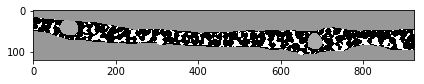

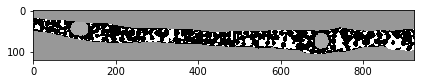

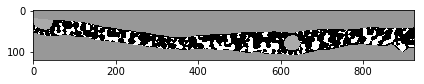

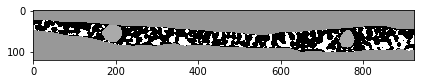

In [164]:
# Read composite stack including slabelling of stomata
composite_stack = io.imread(filepath + 'Dennstaedtia-cicutaria-COMPOSITE-topLeaf-cropped-w-stomata.tif')
purified_stack = io.imread(filepath + 'Purified.tif')
# outline_stack = io.read(filepath + )
print(composite_stack.shape)
print(np.unique(composite_stack)) # to get all the unique values

DisplayRndSlices(composite_stack, 4)



[0 1]
float32
uint8


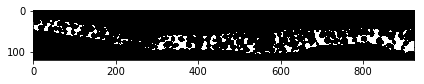

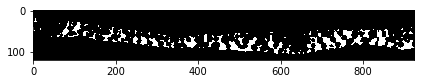

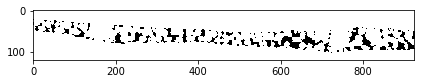

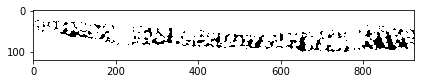

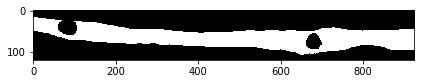

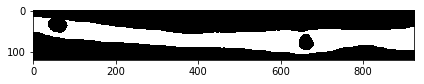

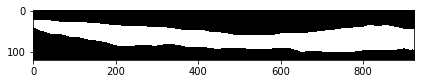

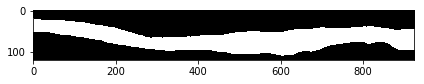

In [10]:
# Create the binary stacks needed for the analysis
mesophyll_wo_veins_stack = np.asarray(Threshold(composite_stack, [0,255]), np.float32)
mesophyll_stack = np.asarray(Threshold(composite_stack, [0,170,255]), np.float32)
cell_stack = np.asarray(Threshold(composite_stack, [0,170,152]), np.float32)
airspace_stack = np.asarray(Threshold(composite_stack, 255), np.float32)
stomata_stack = np.asarray(Threshold(composite_stack, 85), np.uint8)
print(np.unique(stomata_stack))
print(airspace_stack.dtype)
print(stomata_stack.dtype)

DisplayRndSlices(airspace_stack, 2)
DisplayRndSlices(cell_stack, 2)
DisplayRndSlices(mesophyll_wo_veins_stack, 2)
DisplayRndSlices(mesophyll_stack, 2)

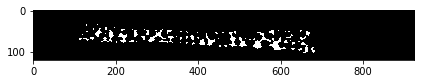

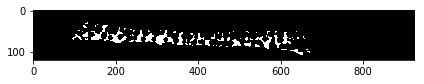

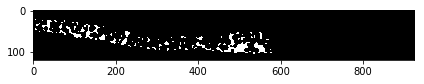

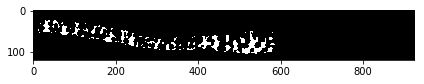

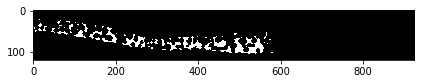

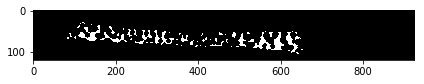

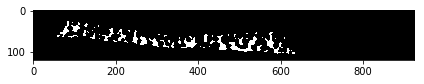

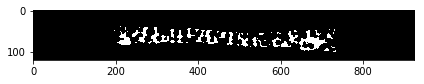

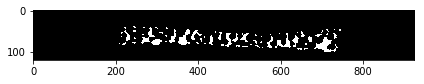

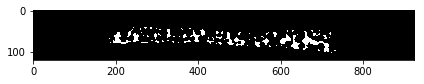

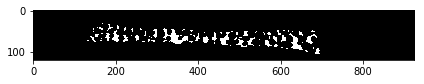

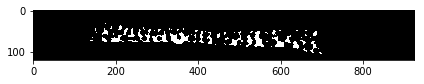

In [214]:
# Purify the airspace stack, i.e. get the largest connected component
largest_airspace = np.asarray(getLargestAirspace(airspace_stack), dtype='float32')
DisplayRndSlices(largest_airspace, 4)
DisplayRndSlices(purified_stack, 4)

# io.imsave(filepath + 'Python-purified.tif', img_as_ubyte(largest_airspace))

purified_python = io.imread(filepath + 'Python-purified.tif')
purified_python = np.asarray(purified_python, dtype='uint8')
DisplayRndSlices(purified_python, 4)



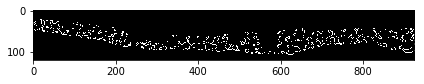

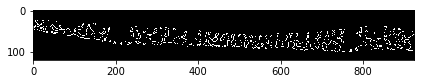

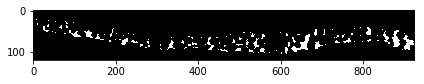

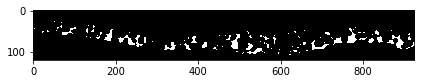

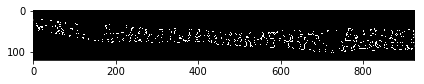

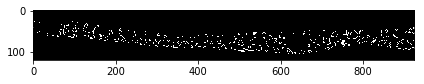

In [268]:
# Detect edges of airspace
# This still needs to be improved as it produces a 2-pixels wide outline,
# not jsut one pixel at the edge of the airspace
# airspace_outline = Outline3D(airspace_stack)
# DisplayRndSlices(airspace_outline, 4)

airspace_outline_mask = airspace_outline / airspace_outline.max()
DisplayRndSlices(airspace_outline_mask,2)

airspace_outline_smaller = ndimage.morphology.binary_erosion(airspace_stack)
DisplayRndSlices(airspace_outline_smaller,2)

airspace_edge = Threshold(cell_stack + airspace_outline_smaller, 0)
DisplayRndSlices(airspace_edge, 2)

# cell_outline = EdgeDetector3D(cell_stack)
# airspace_outline = EdgeDetector3D(airspace_stack)
# epidermis_edge = EdgeDetector3D(mesophyll_stack)
# airspace_outline = Outline3D(airspace_stack)
# DisplayRndSlices(airspace_outline, 5)
# DisplayRndSlices(epidermis_edge, 5)
# io.imsave(filepath + '_airspace-outline.tif', img_as_ubyte(airspace_outline))
# io.imsave(filepath + '_cell-outline.tif', img_as_ubyte(cell_outline))
# io.imsave(filepath + 'epidermis-outline.tif', img_as_ubyte(epidermis_edge))

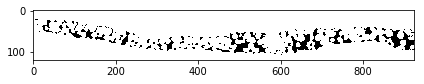

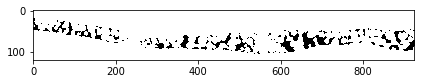

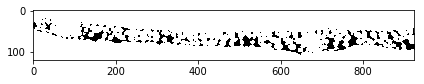

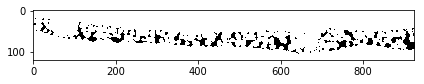

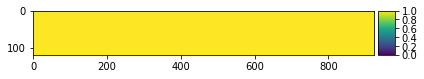

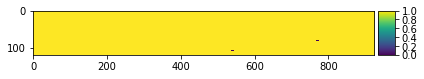

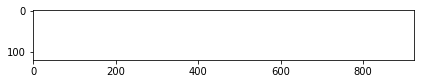

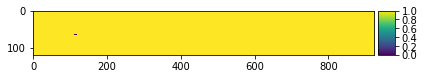

In [113]:
# Get the distance maps
mask = ~airspace_stack.astype(bool)

stom_mask = invert(np.asarray(stomata_stack, dtype='float32'))

DisplayRndSlices(mask, 4)
DisplayRndSlices(stom_mask, 4)

## Get the Euclidian distance from all stomata

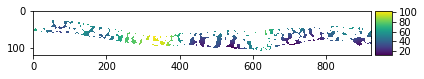

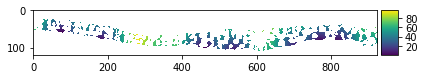

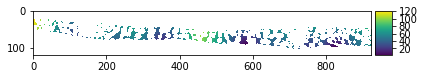

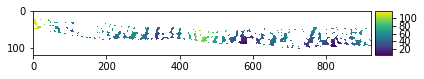

In [117]:
L_euc = np.ma.masked_array(distance_transform_edt(stom_mask), mask)
DisplayRndSlices(L_euc, 4)

## Get the geodesic distance map

In the cell below, a purified stack needs to be used as an input as airspace unconnected to a stomata make the program run into an error (`ValueError: the array phi contains no zero contour (no zero level set)`). I purified in ImageJ, but this could probably be done in python. And the speed is quite good, comaprable to ImageJ.

So, for here, what should be used is an array where all of the airspace is connected to a stomata. How to get that?

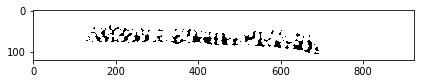

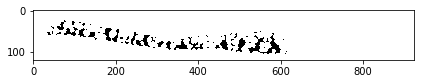

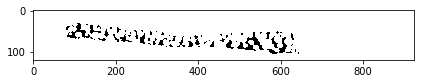

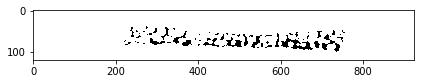

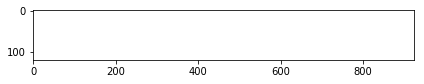

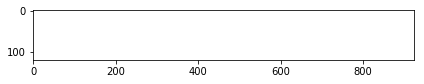

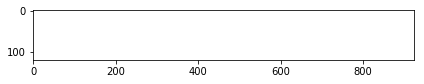

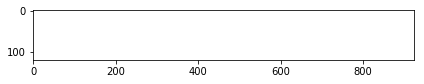

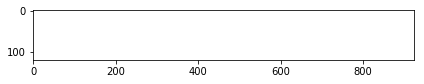

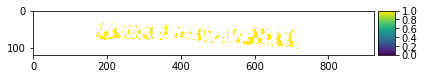

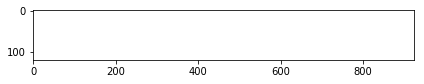

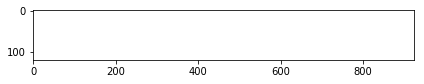

uint8
uint8


In [215]:
# I don't get it here, but ImageJ's purified stack work with the distance transform, 
# but not to the purify done in python. Noth seem to be 8-c0nnected (i.e. including edges). Even when connecting
# only faces (4-conected)

purified_stack_masked_array = np.ma.masked_array(stom_mask, invert(purified_stack))
DisplayRndSlices(purified_stack_masked_array, 4)
# largest_airspace_mask = ~largest_airspace.astype(bool)
# DisplayRndSlices(largest_airspace_mask, 4)
# largest_airspace_masked_array = np.ma.masked_array(stom_mask, invert(purified_python))
# DisplayRndSlices(largest_airspace_masked_array, 4)


# labeled_img = label(purified_stack, background=0, connectivity=1)
# labels_index = np.column_stack((np.unique(labeled_img) ,
#                                    np.bincount(labeled_img.flat)))

# print(purified_stack.dtype)
# print(purified_python.dtype)

In [259]:
# This doesn't work with an airspace purified in python
t0 = time.time()
L_geo = skfmm.distance(purified_stack_masked_array)
t1 = time.time() - t0
print(t1)

5.82890915871


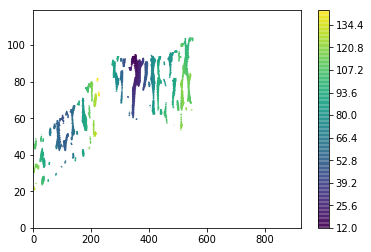

In [191]:
# Oddly, the plot below is inverted. It would be nice to get a paradermal view instead.

# io.imsave(filepath + 'Leuc-4.tif', np.asarray(distance, dtype='float32'))
plt.contour(L_geo[10,:,:], 200)
plt.colorbar()
plt.show()

## Compute the tortuosity factor

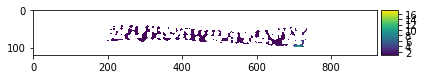

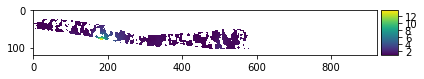

6.5020443676392263

In [301]:
Tortuosity_Factor = (L_geo / L_euc)
DisplayRndSlices(Tortuosity_Factor, 2)
Tortuosity_Factor = Tortuosity_Factor * Tortuosity_Factor
Tortuosity_Factor.mean()
# io.imsave(filepath + 'Python_tortuosity.tif', np.asarray(Tortuosity_Factor, dtype="float32"))

In [298]:
airspace_edge_bool = invert(~airspace_edge.astype(bool))

Tortuosity_at_mesophyll_surface = Tortuosity_Factor[airspace_edge_bool]
Tortuosity_at_mesophyll_surface > 0


masked_array(data = [True True True ..., -- -- --],
             mask = [False False False ...,  True  True  True],
       fill_value = True)

## Compute lateral diffusivity

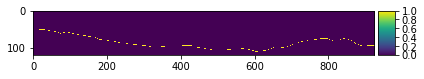

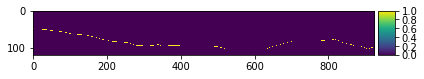

In [250]:
# Get the epidermal layer map
mesophyll_stack_shifted = np.roll(mesophyll_stack, -1, axis=1)
epidermis_edge = Threshold(invert(mesophyll_stack) + mesophyll_stack_shifted, 0)
DisplayRndSlices(epidermis_edge, 2)

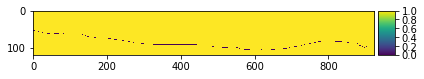

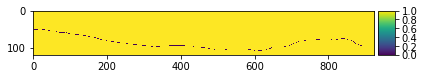

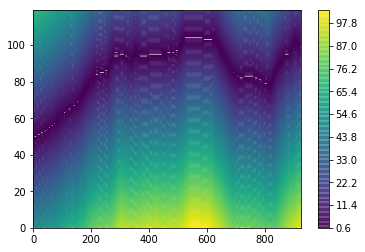

In [260]:
# Compute the 
epidermis_mask = invert(np.asarray(epidermis_edge, dtype='float32'))
DisplayRndSlices(epidermis_mask, 2)

t0 = time.time()
L_epi = distance_transform_edt(epidermis_mask)
t1 = time.time() - t0

plt.contour(L_epi_dt[10,:,:], 200)
plt.colorbar()
plt.show()

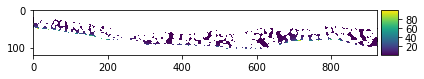

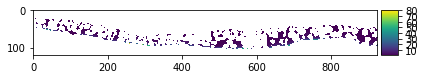

In [264]:
Lateral_diffusivity = (L_euc / L_epi) 
DisplayRndSlices(Lateral_diffusivity, 2)

In [265]:
Lateral_diffusivity.mean()

5.3698005791022059